In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import models
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics

2022-12-22 16:35:15.206904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setting  Dataset

In [2]:
# import the raw data and label
df_data = pd.read_csv('weather_features.csv')
df_label = pd.read_csv('energy_dataset.csv')

print('Data shape: ', df_data.shape)
print('Label shape: ', df_label.shape)

Data shape:  (178396, 17)
Label shape:  (35064, 29)


In [3]:
# visualizing the data
info_weather = df_data.columns.to_list()
print('weather information: ', info_weather)
df_data.head()

weather information:  ['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'weather_id', 'weather_main', 'weather_description', 'weather_icon']


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [4]:
# visualizing the label
info_energy = df_label.columns.to_list()
print('energy information: ', info_energy)
df_label.head()

energy information:  ['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual']


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17,NaN,6436,26118,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16,NaN,5856,24934,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8,NaN,5454,23515,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2,NaN,5151,22642,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9,NaN,4861,21785,20264.0,38.41,56.04


In [5]:
#creating dataset
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
def create_dataframe(dataset,date_cols=[],rename_columns=False,
                   remove_cols=False,cols_to_remove=[],
                   datecol_to_group=None,break_time_cols=False,agg_func="mean",
                   change_to_cat=False,cols_to_cat=[]):
    
    new_dataset = dataset.copy()
    #change col to categorical applying one hot encode for categorical cols
    if change_to_cat:
        ohe = OneHotEncoder().fit(new_dataset.loc[:,cols_to_cat])
        for col in cols_to_cat:
            new_dataset[f"{col}"] = pd.Categorical(new_dataset[f"{col}"])
        new_cat_cols = [f"is_{c}" for c in ohe.categories_[0]]
        new_dataset.loc[:,new_cat_cols] = ohe.transform(new_dataset.loc[:,cols_to_cat]).toarray()
    #remove cols
    if remove_cols:
        new_dataset = new_dataset.drop(labels=cols_to_remove,axis=1)
    #convert the date columns to timestamp and create a new column just for date
    if len(date_cols)>0:
        for col in date_cols:
            new_dataset[f"{col}_date"] = [datetime.fromisoformat(d).date() for d in new_dataset[f"{col}"]]
    #break the date by year,month and day
    if break_time_cols:
        for col in date_cols:
            new_dataset[f"{col}_year"] = [d.year for d in new_dataset[f"{col}_date"]]
            new_dataset[f"{col}_month"] = [d.month for d in new_dataset[f"{col}_date"]]
            new_dataset[f"{col}_day"] = [d.day for d in new_dataset[f"{col}_date"]]
    #remove blank spaces in columns and replace by "_"
    if rename_columns:
        new_c = {c:c.replace(" ","_") for c in new_dataset.columns.to_list()}
        new_dataset = new_dataset.rename(new_c,axis="columns")
    
    #create dataset with timestamp index
    new_dataframe = new_dataset.groupby([f"{datecol_to_group}_date"]).agg(agg_func)
    #rename index col
    if new_dataframe.index.name != "datetime":
        new_dataframe.index = new_dataframe.index.rename("datetime")
    
    
    return new_dataframe

In [6]:
rm_cols_enrg = ["generation hydro pumped storage aggregated","forecast solar day ahead","forecast wind offshore eday ahead",
                "forecast wind onshore day ahead", "total load forecast","price day ahead","price actual"]
rm_cols_wth = ["city_name","weather_id", "weather_description","weather_icon"]
df_enrg = create_dataframe(df_label,date_cols=["time"],rename_columns=True,
                             datecol_to_group="time",remove_cols=True,cols_to_remove=rm_cols_enrg,break_time_cols=False)

df_wth = create_dataframe(df_data,date_cols=["dt_iso"],remove_cols=True,cols_to_remove=rm_cols_wth,
                         datecol_to_group="dt_iso",break_time_cols=False,change_to_cat=True,cols_to_cat=["weather_main"])

print("shape of energy dataset:",df_enrg.shape)
print("shape of weather features dataset:",df_wth.shape)

/var/folders/xs/czbcl2yd5kz2rd9kzqqrmccm0000gn/T/ipykernel_62363/190139131.py:36: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_dataframe = new_dataset.groupby([f"{datecol_to_group}_date"]).agg(agg_func)


shape of energy dataset: (1461, 21)
shape of weather features dataset: (1461, 23)


/var/folders/xs/czbcl2yd5kz2rd9kzqqrmccm0000gn/T/ipykernel_62363/190139131.py:36: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_dataframe = new_dataset.groupby([f"{datecol_to_group}_date"]).agg(agg_func)


In [7]:
df_wth

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,...,is_drizzle,is_dust,is_fog,is_haze,is_mist,is_rain,is_smoke,is_snow,is_squall,is_thunderstorm
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01,276.928845,276.928845,276.928845,1021.991667,75.391667,1.950000,181.600000,0.000000,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2015-01-02,277.897585,277.897585,277.897585,1024.441667,77.833333,1.575000,214.408333,0.000000,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2015-01-03,278.817864,278.817864,278.817864,1020.741667,78.591667,1.575000,191.033333,0.000000,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2015-01-04,279.630031,279.630031,279.630031,1015.858333,76.766667,1.258333,156.408333,0.042500,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.000000,0.141667,0.0,0.0,0.0,0.0
2015-01-05,279.032920,279.032920,279.032920,1014.508333,81.158333,1.150000,174.300000,0.012500,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.000000,0.041667,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,280.702033,279.563496,282.075691,1027.178862,81.211382,1.504065,174.186992,0.000000,0.0,0.0,...,0.00000,0.0,0.130081,0.0,0.130081,0.000000,0.0,0.0,0.0,0.0
2018-12-28,281.067398,279.897967,282.467073,1028.008130,82.593496,1.951220,176.162602,0.002439,0.0,0.0,...,0.04878,0.0,0.040650,0.0,0.235772,0.008130,0.0,0.0,0.0,0.0
2018-12-29,281.231583,280.291667,282.350000,1029.375000,78.708333,2.791667,176.241667,0.007500,0.0,0.0,...,0.00000,0.0,0.008333,0.0,0.125000,0.025000,0.0,0.0,0.0,0.0


In [8]:
# Merge the two datasets
df = df_wth.join(df_enrg['total_load_actual'],on="datetime",how="inner")
print("cols:",df.columns.to_list())
df.head()

cols: ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'is_clear', 'is_clouds', 'is_drizzle', 'is_dust', 'is_fog', 'is_haze', 'is_mist', 'is_rain', 'is_smoke', 'is_snow', 'is_squall', 'is_thunderstorm', 'total_load_actual']


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,...,is_dust,is_fog,is_haze,is_mist,is_rain,is_smoke,is_snow,is_squall,is_thunderstorm,total_load_actual
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01,276.928845,276.928845,276.928845,1021.991667,75.391667,1.950000,181.600000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,23896.750000
2015-01-02,277.897585,277.897585,277.897585,1024.441667,77.833333,1.575000,214.408333,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,27251.291667
2015-01-03,278.817864,278.817864,278.817864,1020.741667,78.591667,1.575000,191.033333,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,25110.666667
2015-01-04,279.630031,279.630031,279.630031,1015.858333,76.766667,1.258333,156.408333,0.0425,0.0,0.0,...,0.0,0.0,0.0,0.0,0.141667,0.0,0.0,0.0,0.0,27112.625000
2015-01-05,279.032920,279.032920,279.032920,1014.508333,81.158333,1.150000,174.300000,0.0125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,22559.444444


In [9]:
# Since this project will need to use 2 dataset, store the raw dataset into CSV. Then do some little change in Excel.
Data = pd.DataFrame()
Data = df
Data.to_csv('ml_data.csv')

## Preprocessing  Dataset

Basic preprocessing process 1 for 4 models(NN, Conv1D, RF, XGB)

In [2]:
#Import the dataset which has a column time
data = pd.read_csv('ml_data1.csv')
data

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,...,is_fog,is_haze,is_mist,is_rain,is_smoke,is_snow,is_squall,is_thunderstorm,day_num,total_load_actual
0,276.928845,276.928845,276.928845,1021.991667,75.391667,1.950000,181.600000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1,23896.75000
1,277.897585,277.897585,277.897585,1024.441667,77.833333,1.575000,214.408333,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,2,27251.29167
2,278.817864,278.817864,278.817864,1020.741667,78.591667,1.575000,191.033333,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,3,25110.66667
3,279.630031,279.630031,279.630031,1015.858333,76.766667,1.258333,156.408333,0.042500,0.0,0.0,...,0.000000,0.0,0.000000,0.141667,0.0,0.0,0.0,0.0,4,27112.62500
4,279.032920,279.032920,279.032920,1014.508333,81.158333,1.150000,174.300000,0.012500,0.0,0.0,...,0.000000,0.0,0.000000,0.041667,0.0,0.0,0.0,0.0,5,22559.44444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,280.702032,279.563496,282.075691,1027.178862,81.211382,1.504065,174.186992,0.000000,0.0,0.0,...,0.130081,0.0,0.130081,0.000000,0.0,0.0,0.0,0.0,1457,28532.20833
1457,281.067398,279.897967,282.467073,1028.008130,82.593496,1.951220,176.162602,0.002439,0.0,0.0,...,0.040650,0.0,0.235772,0.008130,0.0,0.0,0.0,0.0,1458,28637.75000
1458,281.231583,280.291667,282.350000,1029.375000,78.708333,2.791667,176.241667,0.007500,0.0,0.0,...,0.008333,0.0,0.125000,0.025000,0.0,0.0,0.0,0.0,1459,26636.75000
1459,280.159274,278.972581,281.601613,1029.822581,74.451613,2.830645,159.112903,0.000000,0.0,0.0,...,0.080645,0.0,0.040323,0.000000,0.0,0.0,0.0,0.0,1460,25263.91667


In [4]:
#shuffle the training set
'''
from sklearn.utils import shuffle
data = shuffle(data)
data
'''

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,...,is_fog,is_haze,is_mist,is_rain,is_smoke,is_snow,is_squall,is_thunderstorm,day_num,total_load_actual
143,290.005654,290.005654,290.005654,1001.300000,66.825000,2.275000,207.250000,0.152500,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.266667,0.0,0.0,0.000000,0.000000,144,22943.54167
840,287.765785,286.282231,289.637603,1021.528926,56.190083,3.636364,87.223140,0.029752,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.041322,0.0,0.0,0.000000,0.000000,841,28154.12500
1266,297.477583,296.541667,298.358333,1018.150000,58.425000,2.125000,149.450000,0.000000,0.000000,0.0000,...,0.008333,0.000000,0.016667,0.000000,0.0,0.0,0.008333,0.000000,1267,30805.33333
34,277.506754,277.506754,277.506754,993.116667,68.825000,5.125000,227.266667,0.440000,0.000000,2.5625,...,0.000000,0.000000,0.000000,0.416667,0.0,0.0,0.000000,0.000000,35,23822.95833
1296,297.340750,296.491667,298.241667,1014.666667,59.725000,2.625000,180.016667,0.022500,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.058333,0.0,0.0,0.000000,0.000000,1297,31460.08333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,292.730198,290.322500,295.558929,1015.158730,63.150794,2.428571,160.031746,0.097619,0.000000,0.0000,...,0.000000,0.000000,0.015873,0.150794,0.0,0.0,0.000000,0.000000,266,28384.45833
271,292.008609,289.295786,294.995867,1017.725806,71.217742,2.435484,146.266129,0.058065,0.001452,0.0000,...,0.056452,0.016129,0.024194,0.056452,0.0,0.0,0.000000,0.032258,272,28082.66667
403,285.511583,283.841667,287.615833,1023.408333,66.408333,4.666667,220.433333,0.000000,0.000000,0.0000,...,0.033333,0.025000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,404,31090.00000
83,280.998197,280.998197,280.998197,1009.483333,73.550000,4.650000,194.341667,1.810000,0.000000,0.0000,...,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,84,30929.00000


In [3]:
# delete columns which have more than 80 percent of constant values
def preprocessing(dataframe):
    new_dataframe = dataframe.copy()
    #applying StandardScaler
    if len(new_dataframe.shape)>1:
        #remove cols with constant values
        thr = int(dataframe.shape[0]*0.8)
        rm_cols = []
        for col in new_dataframe.columns:
            values,counts = np.unique(new_dataframe[col],return_counts=True)
            if (len(values)==1) or (np.any(counts>thr)):
                rm_cols.append(col)
                
        new_dataframe = new_dataframe.drop(labels=rm_cols,axis="columns")
        
    else:
        scaler.fit(new_dataframe.values.reshape(-1,1))
        new_values = scaler.fit_transform(new_dataframe.values.reshape(-1,1))
        new_dataframe = new_values
        
    return new_dataframe

In [4]:
data = preprocessing(data)

In [5]:
# Convert pandas.DataFrame to np.array for training
data = np.array(data)
data[0]

array([2.76928845e+02, 2.76928845e+02, 2.76928845e+02, 1.02199167e+03,
       7.53916667e+01, 1.95000000e+00, 1.81600000e+02, 0.00000000e+00,
       7.66666667e-01, 9.66666667e-01, 3.33333330e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 2.38967500e+04])

In [6]:
#Divide the dataset into a data set and a label set
label = data[:,-1]
data = np.delete(data, -1, axis=1)
label.shape

(1461,)

In [7]:
# Devide data into a training set and a testing set
training_data = data[0:1169,:]
training_label = label[0:1169]
testing_data = data[1169:,:]
testing_label = label[1169:]

In [8]:
training_data.shape

(1169, 17)

Preprocessing 1: In normal neural network and Conv1D, data needs to be normarlized

In [9]:
# Normalize data
a = training_data.mean(axis=0)
b = training_data.std(axis=0)

training_data_1 = (training_data - a) / b

testing_data_1 = (testing_data - a) / b

training_label_1 = training_label
testing_label_1 = testing_label

Preprocessing 2: In random forest and XGboost, data does not need to be normalized, so just enter the data after previous preprocessing.

In [9]:
training_data_2 = training_data
testing_data_2 = testing_data

training_label_2 = training_label
testing_label_2 = testing_label

Basic preprocessing 2 for LSTM and Conv2D.

In LSTM and Conv2D, after normalizing the data, I need to reshape data(samples, features) to data(samples, timesteps, features). I want to use 7 days data to predict the next day. (Import a new dataset which is removed the day number column)

In [2]:
#Import the new dataset
data3 = pd.read_csv('ml_data3.csv')
data3

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,...,is_dust,is_fog,is_haze,is_mist,is_rain,is_smoke,is_snow,is_squall,is_thunderstorm,total_load_actual
0,276.928845,276.928845,276.928845,1021.991667,75.391667,1.950000,181.600000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,23896.75000
1,277.897585,277.897585,277.897585,1024.441667,77.833333,1.575000,214.408333,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,27251.29167
2,278.817864,278.817864,278.817864,1020.741667,78.591667,1.575000,191.033333,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,25110.66667
3,279.630031,279.630031,279.630031,1015.858333,76.766667,1.258333,156.408333,0.042500,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.141667,0.0,0.0,0.0,0.0,27112.62500
4,279.032920,279.032920,279.032920,1014.508333,81.158333,1.150000,174.300000,0.012500,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.041667,0.0,0.0,0.0,0.0,22559.44444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,280.702032,279.563496,282.075691,1027.178862,81.211382,1.504065,174.186992,0.000000,0.0,0.0,...,0.0,0.130081,0.0,0.130081,0.000000,0.0,0.0,0.0,0.0,28532.20833
1457,281.067398,279.897967,282.467073,1028.008130,82.593496,1.951220,176.162602,0.002439,0.0,0.0,...,0.0,0.040650,0.0,0.235772,0.008130,0.0,0.0,0.0,0.0,28637.75000
1458,281.231583,280.291667,282.350000,1029.375000,78.708333,2.791667,176.241667,0.007500,0.0,0.0,...,0.0,0.008333,0.0,0.125000,0.025000,0.0,0.0,0.0,0.0,26636.75000
1459,280.159274,278.972581,281.601613,1029.822581,74.451613,2.830645,159.112903,0.000000,0.0,0.0,...,0.0,0.080645,0.0,0.040323,0.000000,0.0,0.0,0.0,0.0,25263.91667


In [3]:
# delete columns which have more than 80 percent of constant values
def preprocessing(dataframe):
    new_dataframe = dataframe.copy()
    #applying StandardScaler
    if len(new_dataframe.shape)>1:
        #remove cols with constant values
        thr = int(dataframe.shape[0]*0.8)
        rm_cols = []
        for col in new_dataframe.columns:
            values,counts = np.unique(new_dataframe[col],return_counts=True)
            if (len(values)==1) or (np.any(counts>thr)):
                rm_cols.append(col)
                
        new_dataframe = new_dataframe.drop(labels=rm_cols,axis="columns")
        
    else:
        scaler.fit(new_dataframe.values.reshape(-1,1))
        new_values = scaler.fit_transform(new_dataframe.values.reshape(-1,1))
        new_dataframe = new_values
        
    return new_dataframe

In [4]:
data3 = preprocessing(data3)

In [5]:
# Convert pandas.DataFrame to np.array for training
data3 = np.array(data3)
data3[0]

array([2.76928845e+02, 2.76928845e+02, 2.76928845e+02, 1.02199167e+03,
       7.53916667e+01, 1.95000000e+00, 1.81600000e+02, 0.00000000e+00,
       7.66666667e-01, 9.66666667e-01, 3.33333330e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.38967500e+04])

In [6]:
#Divide the dataset into a data set and a label set
label_3 = data3[:,-1]
data3 = np.delete(data3, -1, axis=1)
label_3.shape

(1461,)

In [7]:
#Convert 1-D label set to 2-D.
label_3 = label_3.reshape(1461,1)

In [9]:
label_3.shape

(1461, 1)

In [10]:
# Devide data into a training set and a testing set
training_data_3 = data3[0:1169,:]
training_label_3 = label_3[0:1169]
testing_data_3 = data3[1169:,:]
testing_label_3 = label_3[1169:]

In [11]:
# Normalize data
c = training_data_3.mean(axis=0)
d = training_data_3.std(axis=0)

training_data_3 = (training_data_3 - c) / d

testing_data_3 = (testing_data_3 - c) / d

In [12]:
# Build time series dataset
X_length = 1169

slider = 7
slider1 = 1

#start = np.cumsum(X_length) - X_length
#end   = np.cumsum(X_length)

X_train_all = []
y_train_all = []


#X_subset = X_train[start[i]:end[i],:]
#y_subset = y_train[start[i]:end[i],:]
X_subset  = np.array([training_data_3[i:i+slider] for i in range(X_length - slider + 1)])
y_subset = np.array([training_label_3[i:i+slider1] for i in range(X_length - slider + 1)])
    
X_train_all.append(X_subset)
y_train_all.append(y_subset)
    

X_train = np.concatenate(X_train_all,axis=0)
y_train = np.concatenate(y_train_all,axis=0)
X_test  = np.array([testing_data_3[i:i+slider] for i in range(287 - slider + 1)])
y_test  = np.array([testing_label_3[i:i+slider1] for i in range(287 - slider + 1)])
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1163, 7, 16) (1163, 1, 1) (281, 7, 16) (281, 1, 1)


# Building model

1. normal neural network

In [10]:
# Define basic architecture
model_1 = models.Sequential()

model_1.add(layers.Dense(128, activation='relu', input_shape=(training_data.shape[1],)))
model_1.add(layers.Dense(128, activation='relu'))
model_1.add(layers.Dense(128, activation='relu'))
#model_1.add(layers.Dense(32, activation='relu'))
model_1.add(layers.Dense(1))
            
model_1.compile(optimizer='Adam', loss = 'mse', metrics=['mae'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2304      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 35,457
Trainable params: 35,457
Non-trainable params: 0
_________________________________________________________________


2022-12-20 16:48:55.478788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [12]:
# To avoid overfitting, setting a early stop if val_loss stop decreasing about 20 epoches
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Training the model
history1 = model_1.fit(training_data_1, training_label_1, epochs=1000,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop, PrintDot()])

Epoch 1/1000
30/30 [==============================] - 0s 3ms/step - loss: 822262528.0000 - mae: 28539.8613 - val_loss: 852009792.0000 - val_mae: 29058.4961
Epoch 2/1000
30/30 [==============================] - 0s 1ms/step - loss: 815398336.0000 - mae: 28419.4375 - val_loss: 837475136.0000 - val_mae: 28806.8887
Epoch 3/1000
30/30 [==============================] - 0s 1ms/step - loss: 770144320.0000 - mae: 27609.8125 - val_loss: 768836352.0000 - val_mae: 27581.0098
Epoch 4/1000
30/30 [==============================] - 0s 1ms/step - loss: 612629568.0000 - mae: 24524.2930 - val_loss: 578888384.0000 - val_mae: 23763.0078
Epoch 5/1000
30/30 [==============================] - 0s 1ms/step - loss: 312536896.0000 - mae: 16753.5488 - val_loss: 299579712.0000 - val_mae: 15937.8564
Epoch 6/1000
30/30 [==============================] - 0s 1ms/step - loss: 111622976.0000 - mae: 8899.8906 - val_loss: 169060800.0000 - val_mae: 11188.5664
Epoch 7/1000
30/30 [==============================] - 0s 1ms/step

Epoch 54/1000
30/30 [==============================] - 0s 1ms/step - loss: 8670560.0000 - mae: 2351.2332 - val_loss: 9448025.0000 - val_mae: 2488.2158
Epoch 55/1000
30/30 [==============================] - 0s 1ms/step - loss: 8519281.0000 - mae: 2335.3511 - val_loss: 9366560.0000 - val_mae: 2467.4895
Epoch 56/1000
30/30 [==============================] - 0s 1ms/step - loss: 8392062.0000 - mae: 2330.0535 - val_loss: 9464662.0000 - val_mae: 2449.2437
Epoch 57/1000
30/30 [==============================] - 0s 1ms/step - loss: 8393229.0000 - mae: 2310.3000 - val_loss: 9183092.0000 - val_mae: 2435.9299
Epoch 58/1000
30/30 [==============================] - 0s 1ms/step - loss: 8274488.0000 - mae: 2304.6343 - val_loss: 9186603.0000 - val_mae: 2439.6941
Epoch 59/1000
30/30 [==============================] - 0s 1ms/step - loss: 8209165.5000 - mae: 2305.7769 - val_loss: 9328976.0000 - val_mae: 2431.6541
Epoch 60/1000
30/30 [==============================] - 0s 1ms/step - loss: 8109207.0000 - mae:

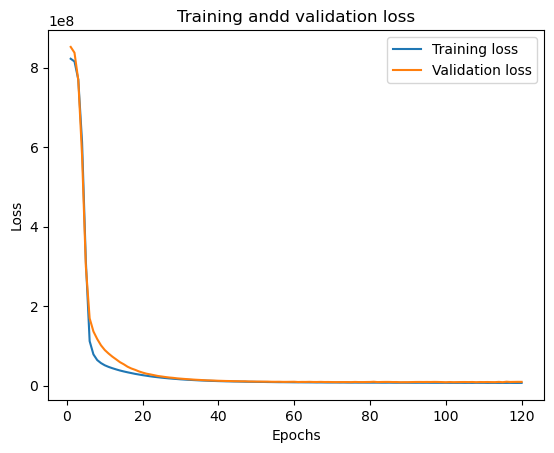

In [13]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training andd validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
# Using test dataset to evaluate the model_1

[loss, mae] = model_1.evaluate(testing_data_1, testing_label_1, verbose=0)

print("Testing set Mean Abs Error: ".format(mae))

Testing set Mean Abs Error: $2393.30


10/10 [==============================] - 0s 499us/step


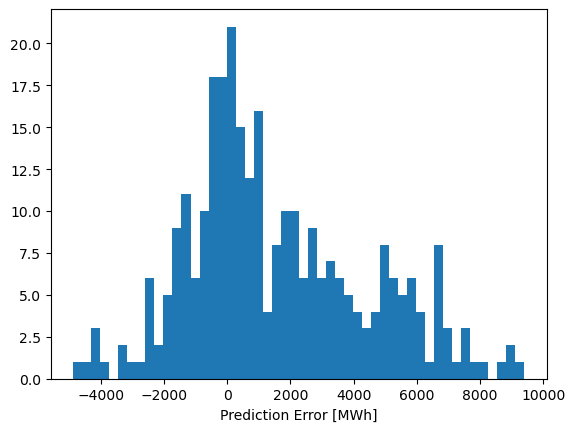

In [15]:
test_predictions_1 = model_1.predict(testing_data_1).flatten()


error = test_predictions_1 - testing_label_1
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [MWh]")
plt.show()



In [25]:
#calculate mse
MSE = []
for i in error:
    mse = i**2
    MSE.append(mse)
MSE = np.array(MSE)

e = np.sum(MSE) / 292
e
#print('MSE = ', e)

10554434.569123704

2. CNN(Conv1D)

In [26]:
# Define basic architecture
model_2 = models.Sequential()

model_2.add(layers.Conv1D(32,3, activation = 'relu', input_shape=(17,1)))
model_2.add(layers.MaxPooling1D(2))
#model_2.add(layers.Conv1D(32,3, activation = 'relu'))
#model_2.add(layers.MaxPooling1D(2))
model_2.add(layers.Conv1D(32,3, activation = 'relu'))
model_2.add(layers.GlobalMaxPooling1D())

#model_26.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1))
            
model_2.compile(optimizer='rmsprop', loss = 'mse', metrics=['mae'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 32)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 32)             3104      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                

In [27]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history2 = model_2.fit(training_data_1, training_label_1, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
......................................

In [28]:
[loss, mae] = model_2.evaluate(testing_data_1, testing_label_1, verbose=0)

print("Testing set Mean Abs Error: ".format(mae))

Testing set Mean Abs Error: $2190.46


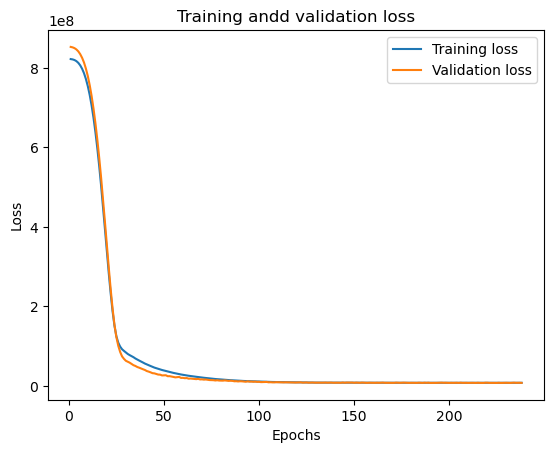

In [29]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training andd validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

10/10 [==============================] - 0s 535us/step


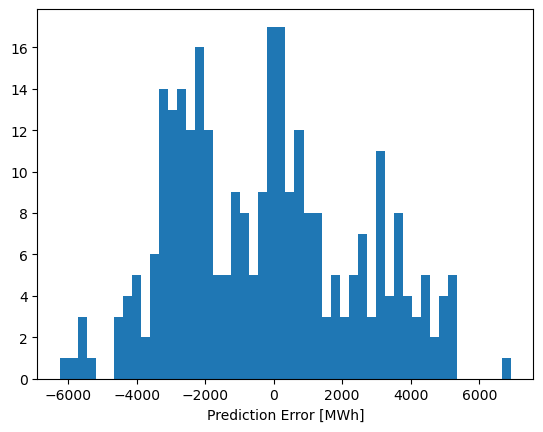

In [30]:
test_predictions_2 = model_2.predict(testing_data_1).flatten()


error_2 = test_predictions_2 - testing_label_1
plt.hist(error_2, bins = 50)
plt.xlabel("Prediction Error [MWh]")
plt.show()

In [31]:
#calculate mse
MSE_2 = []
for i in error_2:
    mse_2 = i**2
    MSE_2.append(mse_2)
MSE_2 = np.array(MSE_2)

e_2 = np.sum(MSE_2) / 292
e_2
#print('MSE = ', e)

7041437.791105069

3. Random Forest

In [10]:
# gradient boosting 
from xgboost import XGBRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor

# evaluation metrics
from sklearn.metrics import mean_squared_error

/Users/1xxx/opt/anaconda3/envs/machine_learning/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [16]:
params_rfr = {'n_estimators':5000,
              'criterion':'mse', 
              'ccp_alpha':0.001,
              'max_depth': 10,
              'min_samples_leaf':1,
              'min_samples_split':5,
              'bootstrap':True,
              'max_features':None}


# XGB parameters (extreme gradient boosting)
params_xgb = {'objective': 'reg:squarederror',
              'base_score': 0.5,     # chosen as median of validation set
              'n_estimators': 5000,  # number of trees to use
              'learning_rate': 0.01, 
              'max_depth': 30,       # how many levels are in each tree
              'subsample': 1,
              'colsample_bytree': 0.8,
               #REGULARIZATION  alpha (L2) and lambda (L1)
              'reg_alpha': 1,
              'reg_lambda': 0,}

In [18]:
model_3 = RandomForestRegressor(**params_rfr)
model_4 = XGBRegressor(**params_xgb)

In [19]:
model_3.fit(training_data_2, training_label_2)
model_4.fit(training_data_2, training_label_2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=30, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=0, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [15]:
test_predictions_3 = model_3.predict(testing_data_2)

mse = mean_squared_error(testing_label_2, test_predictions_3)
print('the mae is', mse)

the mae is 6654933.488093667


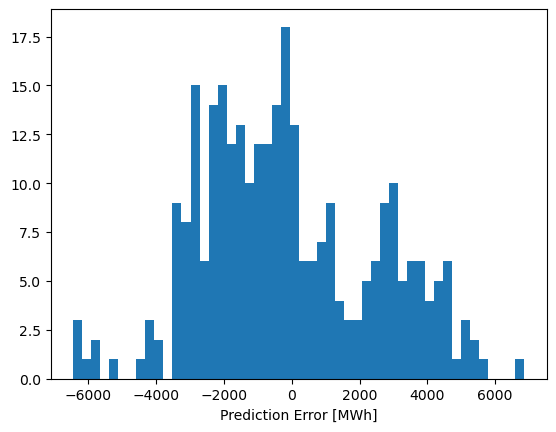

In [16]:
error_3 = test_predictions_3 - testing_label_2
plt.hist(error_3, bins = 50)
plt.xlabel("Prediction Error [MWh]")
plt.show()

In [18]:
#calculate mae
MAE = []
for i in error_3:
    if i >= 0:
        mae = i
    else:
        mae = -i
    
    MAE.append(mae)
MAE = np.array(MAE)

e_3 = np.sum(MAE) / 292
e_3
#print('MAE = ', e)

2106.7782854097195

In [21]:
test_predictions_4 = model_4.predict(testing_data_2)

mse = mean_squared_error(testing_label_2, test_predictions_4)
print('the mse is', mse)

the mse is 7229327.317211201


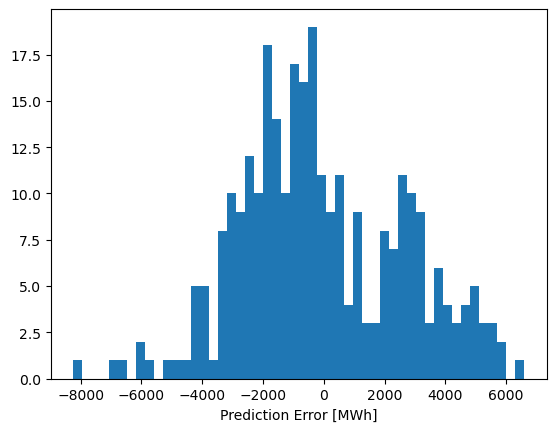

In [22]:
error_4 = test_predictions_4 - testing_label_2
plt.hist(error_4, bins = 50)
plt.xlabel("Prediction Error [MWh]")
plt.show()

In [23]:
#calculate mae
MAE_1 = []
for i in error_4:
    if i >= 0:
        mae_1 = i
    else:
        mae_1 = -i
    
    MAE_1.append(mae_1)
MAE_1 = np.array(MAE_1)

e_4 = np.sum(MAE_1) / 292
e_4
#print('MAE = ', e)

2189.858392504281

4. LSTM

In [13]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 500
learning_rate  = 0.001
minibatch_size = 32
model_num      = 1

In [14]:
# Build the construction
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
import tensorflow as tf

lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train.shape[-1],activation='linear')) 

lstm_model.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             20736     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 57,985
Trainable params: 57,985
Non-trainable params: 0
_________________________________________________________________


2022-12-22 16:36:20.590595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history5 = lstm_model.fit(X_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)

Epoch 1/500
30/30 [==============================] - 1s 9ms/step - loss: 28538.0840 - val_loss: 29067.9785
Epoch 2/500
30/30 [==============================] - 0s 4ms/step - loss: 25038.3438 - val_loss: 28009.0371
Epoch 3/500
30/30 [==============================] - 0s 4ms/step - loss: 20030.6953 - val_loss: 12334.9160
Epoch 4/500
30/30 [==============================] - 0s 4ms/step - loss: 10999.3291 - val_loss: 9713.6172
Epoch 5/500
30/30 [==============================] - 0s 4ms/step - loss: 8462.7559 - val_loss: 8104.2397
Epoch 6/500
30/30 [==============================] - 0s 4ms/step - loss: 7236.9312 - val_loss: 7024.3130
Epoch 7/500
30/30 [==============================] - 0s 4ms/step - loss: 6391.6958 - val_loss: 6172.8428
Epoch 8/500
30/30 [==============================] - 0s 4ms/step - loss: 6060.2017 - val_loss: 5692.9790
Epoch 9/500
30/30 [==============================] - 0s 4ms/step - loss: 5560.6870 - val_loss: 5385.1372
Epoch 10/500
30/30 [============================

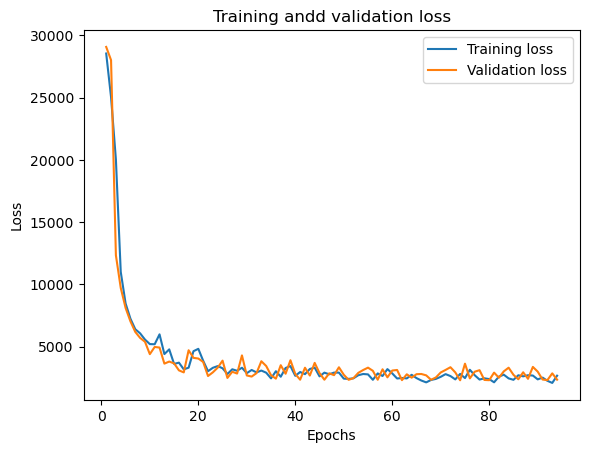

In [16]:
loss = history5.history['loss']
val_loss = history5.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training andd validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

9/9 [==============================] - 0s 2ms/step


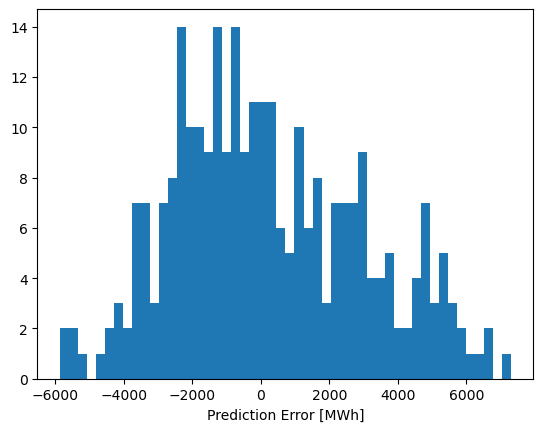

In [17]:
test_predictions_5 = lstm_model.predict(X_test).flatten()
r = y_test.flatten()

error_5 = test_predictions_5 - r
plt.hist(error_5, bins = 50)
plt.xlabel("Prediction Error [MWh]")
plt.show()

In [18]:
#calculate mse
MSE_5 = []
for i in error_5:
    mse_5 = i**2
    MSE_5.append(mse_5)
MSE_5 = np.array(MSE_5)

e_5 = np.sum(MSE_5) / 281
e_5
#print('MSE = ', e)

7652340.124418463

In [19]:
#calculate mae
MAE_5 = []
for i in error_5:
    if i >= 0:
        mae_5 = i
    else:
        mae_5 = -i
    
    MAE_5.append(mae_5)
MAE_5 = np.array(MAE_5)

e_51 = np.sum(MAE_5) / 281
e_51
#print('MAE = ', e)

2247.473572615658

6. Conv2D

In [16]:
# Define basic architecture
model_6 = models.Sequential()

model_6.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(7,16,1)))
model_6.add(layers.MaxPooling2D((2,2)))
model_6.add(layers.Flatten())
model_6.add(layers.Dense(128, activation='relu'))
model_6.add(layers.Dense(128, activation='relu'))
model_6.add(layers.Dense(128, activation='relu'))
#model_6.add(layers.Dense(32, activation='relu'))
model_6.add(layers.Dense(1))
            
model_6.compile(optimizer='Adam', loss = 'mse', metrics=['mae'])

model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 14, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 7, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 128)               57472     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                        

2022-12-22 10:51:51.331891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# To avoid overfitting, setting a early stop if val_loss stop decreasing about 20 epoches
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Training the model
history6 = model_6.fit(X_train, y_train, epochs=1000,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop, PrintDot()])

Epoch 1/1000
30/30 [==============================] - 0s 7ms/step - loss: 819258304.0000 - mae: 28487.4336 - val_loss: 838103616.0000 - val_mae: 28816.8984
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 708911680.0000 - mae: 26425.2461 - val_loss: 504398240.0000 - val_mae: 22260.6680
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 166586288.0000 - mae: 10331.6172 - val_loss: 33174262.0000 - val_mae: 4564.4106
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 42281172.0000 - mae: 4876.5688 - val_loss: 26591272.0000 - val_mae: 4363.6240
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 31366838.0000 - mae: 4083.5955 - val_loss: 26794020.0000 - val_mae: 4436.9985
Epoch 6/1000
30/30 [==============================] - 0s 2ms/step - loss: 26928990.0000 - mae: 3890.3330 - val_loss: 22084826.0000 - val_mae: 3985.6396
Epoch 7/1000
30/30 [==============================] - 0s 2ms/step - loss: 2414

Epoch 108/1000
30/30 [==============================] - 0s 2ms/step - loss: 6576596.5000 - mae: 2073.8572 - val_loss: 8702571.0000 - val_mae: 2395.2639
Epoch 109/1000
30/30 [==============================] - 0s 2ms/step - loss: 6911631.5000 - mae: 2137.1567 - val_loss: 9101335.0000 - val_mae: 2514.7075
Epoch 110/1000
30/30 [==============================] - 0s 2ms/step - loss: 6614969.5000 - mae: 2089.8113 - val_loss: 8772208.0000 - val_mae: 2445.4814
Epoch 111/1000
30/30 [==============================] - 0s 2ms/step - loss: 6645830.0000 - mae: 2095.6436 - val_loss: 8779051.0000 - val_mae: 2388.3481
Epoch 112/1000
30/30 [==============================] - 0s 2ms/step - loss: 6745917.0000 - mae: 2111.5195 - val_loss: 8680185.0000 - val_mae: 2372.0500
Epoch 113/1000
30/30 [==============================] - 0s 2ms/step - loss: 6551931.0000 - mae: 2081.5535 - val_loss: 8576439.0000 - val_mae: 2395.6873
Epoch 114/1000
30/30 [==============================] - 0s 2ms/step - loss: 6681729.0000

Epoch 162/1000
30/30 [==============================] - 0s 2ms/step - loss: 6728173.5000 - mae: 2082.0457 - val_loss: 9303319.0000 - val_mae: 2408.5112
Epoch 163/1000
30/30 [==============================] - 0s 2ms/step - loss: 5900803.5000 - mae: 1958.9960 - val_loss: 9206624.0000 - val_mae: 2400.6311


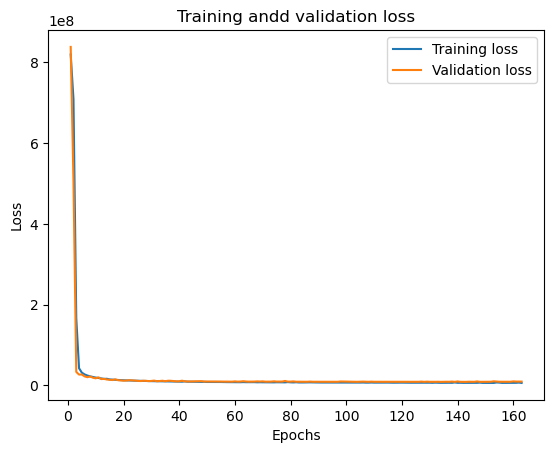

In [19]:
loss = history6.history['loss']
val_loss = history6.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training andd validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
# Using test dataset to evaluate the model_1

[loss, mse] = model_6.evaluate(X_test, y_test, verbose=0)

print("Testing set Mean Abs Error: {:7.2f}".format(mse))

Testing set Mean Abs Error: 2219.69


9/9 [==============================] - 0s 821us/step


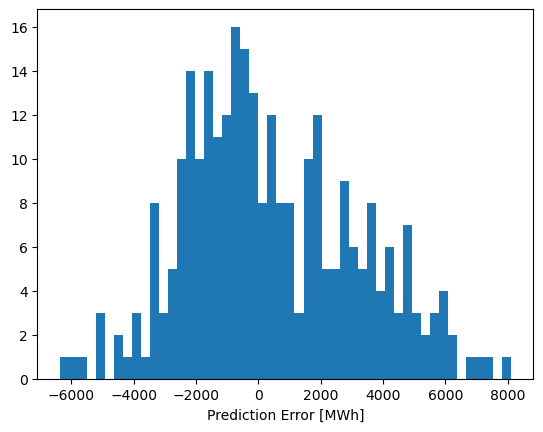

In [22]:
test_predictions_6 = model_6.predict(X_test).flatten()
y = y_test.flatten()

error_6 = test_predictions_6 - y
plt.hist(error_6, bins = 50)
plt.xlabel("Prediction Error [MWh]")
plt.show()

In [23]:
#calculate mse
MSE_6 = []
for i in error_6:
    mse_6 = i**2
    MSE_6.append(mse_6)
MSE_6 = np.array(MSE_6)

e_6 = np.sum(MSE_6) / 281
e_6
#print('MSE = ', e)

7731532.863617756